## Intro

This example project concerns itself with
- predicting the value of a car based on information like mileage, the make and model of the car.
- quantifying depreciation of a car w.r.t the mileage it clocks up


## Mount Google Drive to access car listing data

In [1]:
#@title
## Mounting google drive as a virtual `drive` to gain access to data 
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

path = '/gdrive/My Drive/Python/Tutorials/webscrapping'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


## Import analysis and visualization libraries and set plot aesthetics

In [0]:
!pip install --upgrade yellowbrick

In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, Lasso, ElasticNetCV, ElasticNet
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot, PredictionError, CooksDistance
from statsmodels.api import qqplot
from pprint import pprint

In [0]:
sns.set(style="whitegrid", palette="muted", color_codes=True)

## Import data and check columns and rows

In [0]:
dtype_dict = {'Year':int, 'Make':str, 'Model':str, 'Detailed_model':str, 'Price':float, 'Mileage':int, 'Website': str}
car_listings = pd.read_csv(path + '/car_listings.csv',dtype=dtype_dict)

In [8]:
car_listings.sample(5)

,Year,Make,Model,Detailed_model,Price,Mileage,Website
8784,2016,Hyundai,Sonata,SE,14600.0,36179,ED
7657,2014,Volkswagen,Passat,TDI SEL Premium,16600.0,13010,ED
3276,2018,Honda,Accord,1.5T LX FWD,18999.0,4884,CG
3570,2018,Volkswagen,Passat,NaN,15980.0,5464,CG
6342,2016,Volkswagen,Passat,1.8T SEL Auto,18988.0,24217,TC


In [9]:
desc = car_listings.describe()
desc.applymap(lambda x: int(x))

,Year,Price,Mileage
count,11018,10943,11018
mean,2015,14559,48525
std,2,4972,36511
min,1998,1700,5
25%,2014,11944,24338
50%,2016,14999,39331
75%,2018,17600,60291
max,2019,33500,381748


In [10]:
car_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11018 entries, 0 to 11017
Data columns (total 7 columns):
Year              11018 non-null int64
Make              11018 non-null object
Model             11018 non-null object
Detailed_model    10856 non-null object
Price             10943 non-null float64
Mileage           11018 non-null int64
Website           11018 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 602.7+ KB


The *Price* column has some missing values. Let's remove the rows with no entry for the *Price* column

In [0]:
car_listings = car_listings[car_listings.Price.notnull()]

In [12]:
car_listings.groupby(['Make', 'Model']).agg({'Price':['mean', 'count'], 'Mileage':'mean'})

Price             Mileage
                           mean count          mean
Make       Model                                   
Chevrolet  Malibu  13975.739568   695  42248.130935
Ford       Fusion  14048.936154  1347  49715.406088
Honda      Accord  17985.075795  2045  37069.151589
Hyundai    Sonata  13355.761605  1271  44674.967742
Nissan     Altima  12894.916343  2319  57713.732643
Toyota     Camry   14678.426728  2402  51933.990841
Volkswagen Passat  13631.096065   864  49531.853009

## Removing duplicate values

Car listing websites may allow the same car to be posted several times.
This may negatively affect our analysis so we need to remove duplicate 
entries in the car listing data frame

In [13]:
car_listings.drop(car_listings[car_listings[['Year',	'Make',	'Model',	'Price',	'Mileage']].duplicated()].index, inplace=True)
# After removing duplicates
desc = car_listings.describe()
desc.applymap(lambda x: int(x))

,Year,Price,Mileage
count,6396,6396,6396
mean,2016,15784,42862
std,2,4109,29865
min,1998,1700,5
25%,2015,14000,24388
50%,2017,15892,38792
75%,2018,17830,49565
max,2019,33500,381748


In [23]:
car_listings.groupby(['Make', 'Model']).count()

,,Year,Detailed_model,Price,Mileage,Website
Make,Model,,,,,
Chevrolet,Malibu,370,356,370,370,370
Ford,Fusion,797,796,797,797,797
Honda,Accord,1058,1056,1058,1058,1058
Hyundai,Sonata,743,743,743,743,743
Nissan,Altima,1540,1528,1540,1540,1540
Toyota,Camry,1317,1314,1317,1317,1317
Volkswagen,Passat,571,566,571,571,571


## Correlation matrix  and box plots

In [15]:
car_listings.corr()

,Year,Price,Mileage
Year,1.000000,0.720747,-0.705035
Price,0.720747,1.000000,-0.752231
Mileage,-0.705035,-0.752231,1.000000


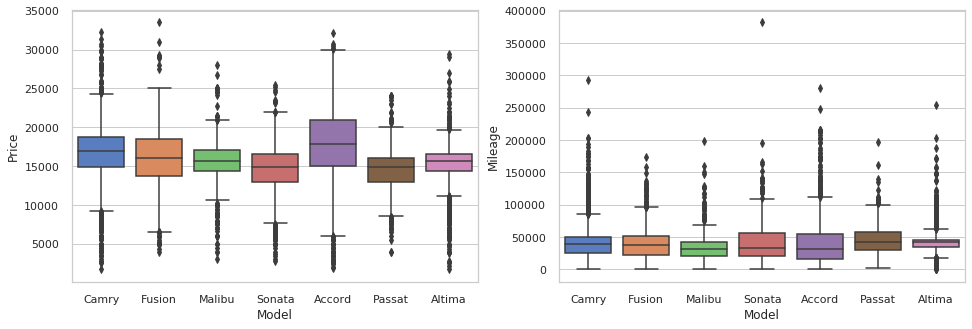

In [26]:
fig = plt.figure(figsize=(16,5))
ax1, ax2 = fig.subplots(1, 2)
sns.boxplot(x="Model", y="Price", data=car_listings,  ax=ax1)
sns.boxplot(x="Model", y="Mileage", data=car_listings, ax=ax2)

## Plotting and model training functions

In [0]:
def plot(make, df=None, plt_type='scatter'):
  if df is None:
    print("data frame none")
    df = car_listings
  fig = plt.figure(figsize=(12,5))
  axes = fig.subplots(1,2)

  for index, column in enumerate(['Mileage', 'Year']):
    # axes[index].set_xticklabels(labels[column])
    if plt_type == 'scatter':
      sns.scatterplot(df[(df.Make == make)][column],df[df.Make == make]['Price'], ax=axes[index])
    elif plt_type == 'kde':
      sns.kdeplot(df[column], ax=axes[index],shade=True)
    axes[index].set_title(make)

In [0]:
def transform(series, transformation):
  '''Transform a series into another series by centering, 
  standardizing or using a custome function
  '''
  if callable(transformation):
    return transformation(series)
  elif transformation == 'center':
    return series - np.mean(series)
  elif transformation == 'standardize':
    return (series - np.mean(series))/np.std(series)

def train_linear_regression(train, regularizer=None):
  ''' Takes in the training set 'train' and performs LASSO(ElasticNet)
  in two steps. First LASSO(ElasticNet) Cross Validation is used to 
  select the alpha regularization hyper-parameter that optimizes 
  between OLS and regularization costs. Second, this parameter is 
  used to train a model'''

  if regularizer is None:
    model = LinearRegression().fit(train.drop('Price', axis=1), train.Price)

  elif regularizer == 'e':
    elasticnet_cv = ElasticNetCV(cv=5, random_state=0, l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
    elasticnet_cv.fit(train.drop('Price', axis=1), train.Price)

    model = ElasticNet(alpha=elasticnet_cv.alpha_, l1_ratio=elasticnet_cv.l1_ratio_, random_state=0)
    model.fit(train.drop('Price', axis=1), train.Price)
  elif regularizer == 'r':
    ridge_cv = RidgeCV(cv=10)
    ridge_cv.fit(train.drop('Price', axis=1), train.Price)

    model = Ridge(random_state=0,alpha=ridge_cv.alpha_)
    model.fit(train.drop('Price', axis=1), train.Price)
  else:
    lasso_cv = LassoCV( cv=10, random_state=0)
    lasso_cv.fit(train.drop('Price', axis=1), train.Price)

    model = Lasso(random_state=0,alpha=lasso_cv.alpha_)
    model.fit(train.drop('Price', axis=1), train.Price)
  return model

def train_test_plot(dataframe, columns, visualize=True, return_test_set=False, regularizer=None):
  '''Splits the data set into training and test sets, 
  trains a regression model, and visualizes the residuals (if vizualise is True)
  '''
  train, test = train_test_split(dataframe[columns],shuffle=True)
  model = train_linear_regression(train, regularizer)

  # Price should be the last in the 'columns' list!
  predicted = dataframe[columns[:-1]].dot(model.coef_) + model.intercept_
  r2_score = model.score(test[columns[:-1]], test['Price'])

  if visualize:
    residual_visualizer = ResidualsPlot(model)

    residual_visualizer.fit(train[columns[:-1]], train['Price'])  
    residual_visualizer.score(test[columns[:-1]], test['Price'])  
    residual_visualizer.poof() 
  if return_test_set:
    return model, test
  return model

In [0]:
def performance(data, columns, rep=10, regularizer=None):
  '''A function for checking the performance of models by 
  repeatedly training the models.
  '''
  result = {
      'coef':[],
      'intercept':[],
      'score':[],
      'RMSE':[]
  }


  for _ in range(rep):
    model, test_set = train_test_plot(data, columns, visualize=False, return_test_set=True, regularizer=regularizer)
    residuals = model.predict(data[columns].drop('Price', axis=1))  -  data['Price']

    result['coef'].append(model.coef_)
    result['intercept'].append(model.intercept_)
    result['score'].append(model.score(test_set.drop('Price', axis=1), test_set.Price))
    result['RMSE'].append(np.sqrt(np.sum(residuals **2) / data.shape[0]))
  coef_means = np.mean(np.array(result['coef']), axis=0)
  coef_std = np.std(np.array(result['coef']), axis=0, ddof=len(result['coef']) - 1)

  intercept_mean = np.mean(result['intercept'])
  intercept_std = np.std(result['intercept'], ddof=len(result['intercept']) - 1)

  score_mean = np.mean(result['score'])
  score_std = np.std(result['score'], ddof=len(result['score']) - 1)

  RMSE_mean = np.mean(result['RMSE'])
  RMSE_std = np.std(result['RMSE'], ddof=len(result['RMSE']) - 1)

  stats = {
      'coef_means': coef_means,
      'coef_CI': list(zip(coef_means - 1.96 * coef_std/np.sqrt(len(result['coef'])), coef_means + 1.96 * coef_std/np.sqrt(len(result['coef'])))),
      'Intercept': {
          'mean': intercept_mean,
          'CI': [intercept_mean - 1.96 * intercept_std/np.sqrt(len(result['intercept'])), intercept_mean + 1.96 * intercept_std/np.sqrt(len(result['intercept']))]
      },
      'R2_on_testset': {
          'mean': score_mean,
          'CI': [score_mean - 1.96 * score_std/np.sqrt(len(result['score'])), score_mean + 1.96 * score_std/np.sqrt(len(result['score']))]
          },
      'RMSE': {
          'mean': RMSE_mean,
          'CI': [RMSE_mean - 1.96 *RMSE_std/np.sqrt(len(result['RMSE'])), RMSE_mean + 1.96 *RMSE_std/np.sqrt(len(result['RMSE']))]
      }
  }
  return stats

## 1. Regression model for Toyota Camry 

### 1.1 Initial analysis

In [40]:
toyota = car_listings[(car_listings.Make == 'Toyota')].copy()
toyota.sort_values(by='Mileage')
toyota.reset_index(inplace=True,drop=True)
toyota.describe().applymap(lambda x: int(x))

,Year,Price,Mileage
count,1317,1317,1317
mean,2016,16438,44794
std,2,4143,32001
min,1998,1700,115
25%,2016,14900,25373
50%,2017,16990,39077
75%,2018,18699,49637
max,2019,32200,293258


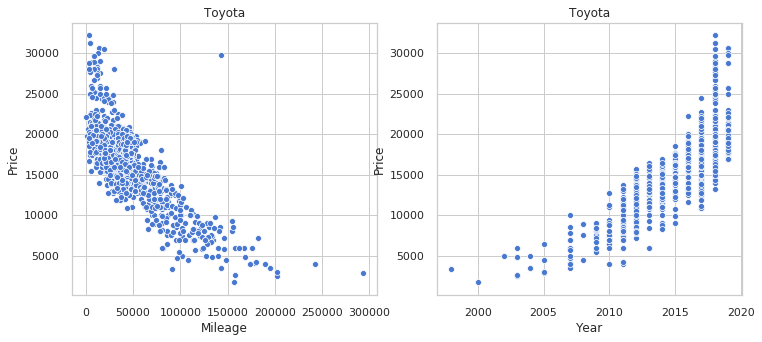

In [33]:
plot('Toyota', toyota)

In [34]:
toyota.corr()

,Year,Price,Mileage
Year,1.000000,0.804108,-0.749551
Price,0.804108,1.000000,-0.782014
Mileage,-0.749551,-0.782014,1.000000


#### Check botton and top ends of the ***Mileage*** and ***Year*** columns for outliers

In [24]:
# Mileage
display(toyota.sort_values(by='Mileage').head())
display(toyota.sort_values(by='Mileage').tail())
display([toyota.Mileage.mean() - (3*toyota.Mileage.std()), toyota.Mileage.mean() + (3*toyota.Mileage.std())])

,Year,Make,Model,Detailed_model,Price,Mileage,Website
735,2019,Toyota,Camry,SE,22100.0,115,ED
787,2019,Toyota,Camry,L,19797.0,1193,ED
738,2019,Toyota,Camry,SE,20691.0,2300,ED
1191,2019,Toyota,Camry,LE,19489.0,2870,ED
736,2018,Toyota,Camry,XSE,32200.0,2893,ED


,Year,Make,Model,Detailed_model,Price,Mileage,Website
632,2007,Toyota,Camry,SE,3494.0,194576,ED
811,2003,Toyota,Camry,XLE,2500.0,202790,ED
1274,2005,Toyota,Camry,LE,2995.0,202840,ED
1300,2010,Toyota,Camry,LE,3995.0,242756,ED
353,2005,Toyota,Camry,LE I4,2845.0,293258,TC


[-50976.16598497629, 140415.73741354773]

We have a handful of cars that are driven more than 3 times the standard deviation of mileage. These could be problematic when trying to fit a regression model as linear regression can be affected by outliers (esp. large ones)

In [41]:
outliers = toyota[toyota.Mileage > toyota.Mileage.mean() + (3*toyota.Mileage.std())]
print(outliers.shape)

(26, 7)


In [42]:
# These 'outliers' are not that many so we can safely drop them
toyota.drop(outliers.index, inplace=True)
toyota.describe()

,Year,Price,Mileage
count,1291.000000,1291.000000,1291.000000
mean,2016.312936,16648.049574,42193.724245
std,2.560216,3841.209513,26071.213471
min,1998.000000,3387.000000,115.000000
25%,2016.000000,14995.000000,25019.500000
50%,2017.000000,16995.000000,38668.000000
75%,2018.000000,18736.000000,48038.500000
max,2019.000000,32200.000000,140630.000000


In [43]:
# Doing the same thing for 'Year'
display(toyota.sort_values(by='Year').head())
display(toyota.sort_values(by='Year').tail())
display([toyota.Year.mean() - (3*toyota.Year.std()), toyota.Year.mean() + (3*toyota.Year.std())])

,Year,Make,Model,Detailed_model,Price,Mileage,Website
321,1998,Toyota,Camry,LE I4,3387.0,90940,TC
320,2002,Toyota,Camry,LE I4,4995.0,101315,TC
17,2003,Toyota,Camry,LE I4,5995.0,81881,TC
377,2003,Toyota,Camry,XLE I4,4800.0,133325,TC
284,2004,Toyota,Camry,LE I4,4923.0,127211,TC


,Year,Make,Model,Detailed_model,Price,Mileage,Website
545,2019,Toyota,Camry,LE,19000.0,3111,ED
783,2019,Toyota,Camry,LE,18299.0,14640,ED
1166,2019,Toyota,Camry,L,19099.0,11716,ED
702,2019,Toyota,Camry,L,18995.0,31647,ED
516,2019,Toyota,Camry,LE,18572.0,17737,TC


[2008.6322862205623, 2023.9935851969437]

In [44]:
outliers_year = toyota[toyota.Year < toyota.Year.mean() - (3*toyota.Year.std())]
print(outliers_year.shape)

(20, 7)


In [0]:
toyota.drop(outliers_year.index, inplace=True)

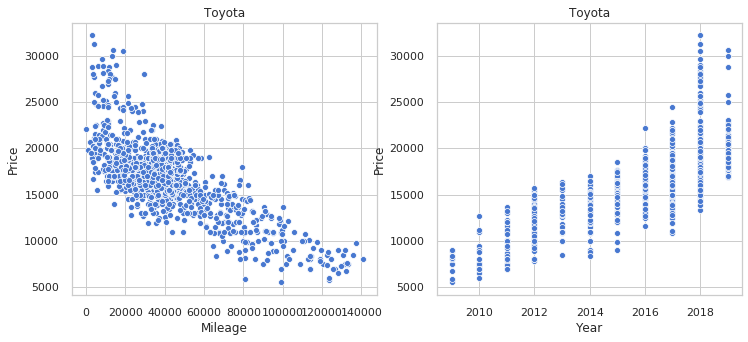

In [46]:
# Plot Mileage-vs-Price and Year-vs-Price after removing outliers
plot('Toyota', toyota)

#### Histograms of ***Mileage***, ***Year*** and ***Price*** columns

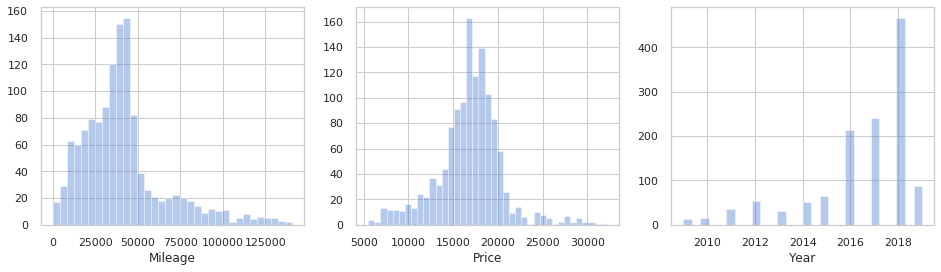

In [47]:
fig = plt.figure(figsize=(16, 4))
axes = fig.subplots(1,3)
sns.distplot(toyota.Mileage, kde=False, ax=axes[0])
sns.distplot(toyota.Price, kde=False, ax=axes[1])
sns.distplot(toyota.Year, kde=False, ax=axes[2])

#### Average price of Toyota Camry by trim level

In [53]:
toyota.groupby(by='Detailed_model').agg({'Mileage':['count', 'mean'], 'Price':[ 'mean']})

Mileage                        Price
                              count           mean          mean
Detailed_model                                                  
2014 Hybrid                       2   64846.500000  13241.000000
2014 L I4                         1   63009.000000  10980.000000
2014 LE I4                       10   72422.400000  12095.200000
2014 SE I4                        4   67080.750000  12883.500000
2014 SE Sport I4                  1   72341.000000  14500.000000
2014 SE V6                        1   70225.000000  16130.000000
2014 XLE I4                       2   52783.000000  16199.000000
2014 XLE V6                       1   31523.000000  16500.000000
Base                              1  113667.000000   6946.000000
Hybrid                           22   46411.318182  18261.818182
I4                                2  106666.000000   8721.500000
L                                42   31905.142857  17637.000000
L I4                             11   34250.818182  17218.090909
LE                              362   39921.212707  16472.049724
LE FWD                            1    9044.000000  19300.000000
LE I4                           164   39268.067073  15745.451220
LE V6                             4  101604.000000   8745.750000
SE                              308   43556.477273  16937.506494
SE I4                           133   41298.338346  16368.278195
SE Limited Edition                1   47460.000000  14600.000000
SE Special Edition I4             1   40407.000000  17500.000000
SE Sport Limited Edition I4       1   92561.000000  10990.000000
SE Used                           1   25467.000000  14699.000000
SE V6                             6   72821.666667  12547.500000
Special Edition                   2   32703.500000  14799.500000
XLE                              62   44721.790323  16677.612903
XLE I4                           41   35039.146341  18122.878049
XLE V6                           15   59629.200000  15694.400000
XSE                              38   27263.605263  21654.210526
XSE I4                           20   30296.950000  20773.600000
XSE V6                           11   14936.545455  28473.454545

### 1.2 Exploring features
---

In [0]:
toyota['Year_ctr'] = transform(toyota.Year, 'center')
toyota['Year_ctr_2019'] = 2019 - toyota.Year
toyota['Mileage_ctr'] = transform(toyota.Mileage, 'center')
toyota['Year_std'] = transform(toyota.Year, 'standardize')
toyota['Year_SQ_std'] = transform((toyota.Year**2), 'standardize')
toyota['Year_SQ_ctr'] = transform((toyota.Year**2), 'center')
toyota['Year_Quad2_std'] = transform(18.92 * toyota.Year**2, 'standardize')
toyota['Year_Quad1_std'] = transform(7.5e4 * toyota.Year, 'standardize')
toyota['Mileage_std'] = transform(toyota.Mileage, 'standardize')
toyota['Mileage_SQRT_std'] = transform(transform(toyota.Mileage, np.sqrt) , 'standardize')
toyota['Mileage_log'] = np.log2(toyota.Mileage)
toyota['Mileage_log_std'] = transform(transform(toyota.Mileage, np.log2), 'standardize')

# Encoding trim-level as a dummy variable
toyota['XLE'] = [1 if entry else 0 for entry in toyota.Detailed_model.str.contains('XLE', na=False)] 
toyota['XSE'] = [1 if entry else 0 for entry in toyota.Detailed_model.str.contains('XSE', na=False)] 
toyota['Hybrid'] = [1 if entry else 0 for entry in toyota.Detailed_model.str.contains('Hybrid', na=False)] 

---

### 1.3 First attempt: Price as a simple linear function of Mileage

$$P_i = w_0 + w_1 M_i$$

where $P_i$ and $M_i$ are the $i^{th}$ price and standardized mileage <br/>
and $w_0$ and $w_1$ are the intercept and weight to be 'learned' by the model

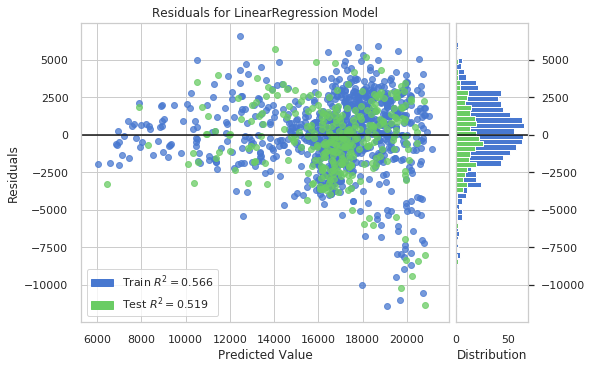

 
w_0 = 16722.35145305303, w_1 = -2669.7864419985635


In [56]:
simple_linear_model = train_test_plot(toyota, ['Mileage_std', 'Price'])
print(" ")
print('w_0 = {}, w_1 = {}'.format(simple_linear_model.intercept_, simple_linear_model.coef_[0]))

The coefficient tells us that for every standardad deviation increase <br/>
in mileage (i.e. roughly for every 31K mileage) the price of a Toyota camry drops by 2699 dollars. 

However the residuals show strong ***heteroscedasticity*** that needs fixing. <br/>
Note that for a simple regression, our model has a high $R^2$ score but before <br/> considering model performance seriously, let us first try to fix the heteroscedasticity

Our model systematically under-predicted the price of the expensive cars.<br/>
As shown in the cell below, these cars also happen to have the least <br/>
mileage.

A linear relationship between mileage and price performs relatively well<br/>
for cars that are driven long enough. However, for those cars that reside <br/>
on the boundaries of being "New" and "Used" (i.e. cars whose mileage is <br/>
within the first few thousands), the effect of other factors is stronger <br/>than mileage.

#### Mileage-vs-Price and Year-vs-Price - two regions of mileage

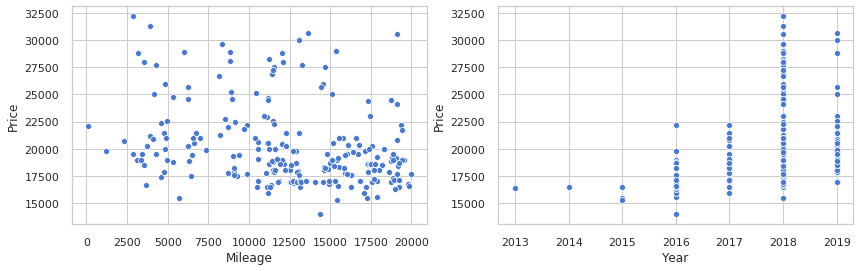

In [58]:
fig = plt.figure(figsize=(14, 4))
axes = fig.subplots(1,2)
sns.scatterplot(toyota[toyota.Mileage < 20000].Mileage, toyota.Price, ax=axes[0])
sns.scatterplot(toyota[toyota.Mileage < 20000].Year, toyota.Price, ax=axes[1])

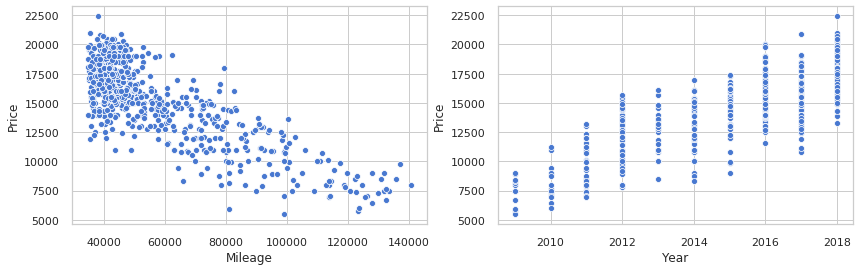

In [59]:
fig = plt.figure(figsize=(14, 4))
axes = fig.subplots(1,2)
sns.scatterplot(toyota[toyota.Mileage > 35000].Mileage, toyota.Price, ax=axes[0])
sns.scatterplot(toyota[toyota.Mileage > 35000].Year, toyota.Price, ax=axes[1])

#### Check if Squareroot transforming ***Mileage*** yields a better model

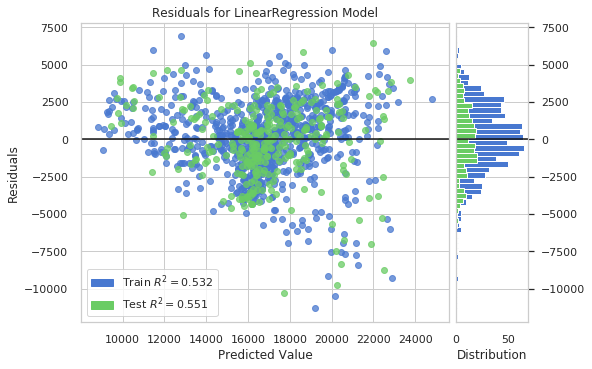

In [60]:
model = train_test_plot(toyota, ['Mileage_SQRT_std', 'Price'])
residuals = model.predict(toyota[['Mileage_SQRT_std']])  -  toyota['Price']

#### Test multicolinearity between ***Mileage*** and ***Year*** using VIF

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_test = toyota[['Mileage', 'Year']].copy()
vif_test['Intercept'] = np.ones(vif_test.shape[0])

pd.Series([variance_inflation_factor(vif_test.values, i) for i in range(vif_test.shape[1])], index=vif_test.columns)

Mileage      2.324958e+00
Year         2.324958e+00
Intercept    1.208486e+06
dtype: float64

###  1.4 Using ***Year*** and trim-level as features along with ***Mileage***

$$P_i = w_0 + w_1 f(Mileage) + w_2 g(Year) + w_3 1_{\{XLE\}} + w_4 1_{\{XSE\}} + w_5 1_{\{Hybrid\}}$$

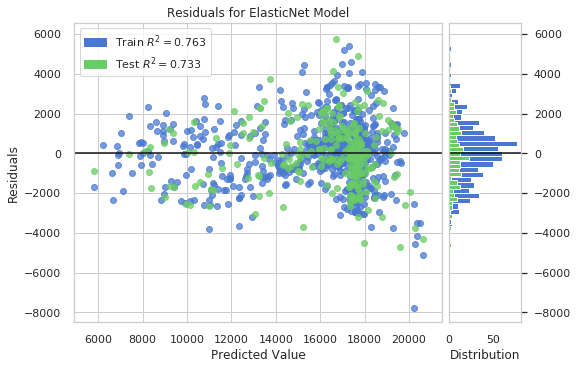

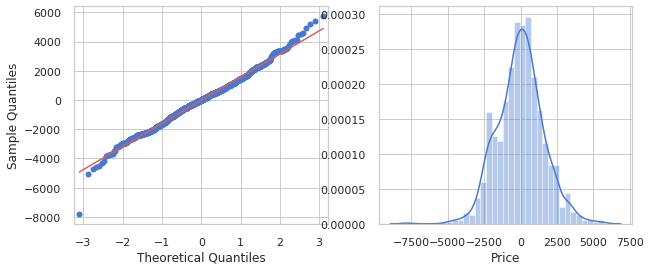

In [78]:
columns = ['Mileage_std', 'Year_std','XLE' ,'XSE', 'Hybrid','Price']
rows = toyota[toyota.Mileage > 20000]
model = train_test_plot(rows, columns, regularizer='e')
residuals = model.predict(rows[columns[:-1]])  -  rows['Price']
fig = plt.figure(figsize=(10,4)); axes = fig.subplots(1,2);
qqplot(residuals, line='r',ax=axes[0]); 
sns.distplot(residuals, ax=axes[1]);

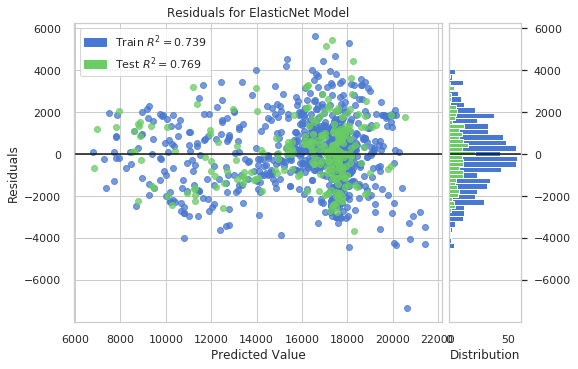

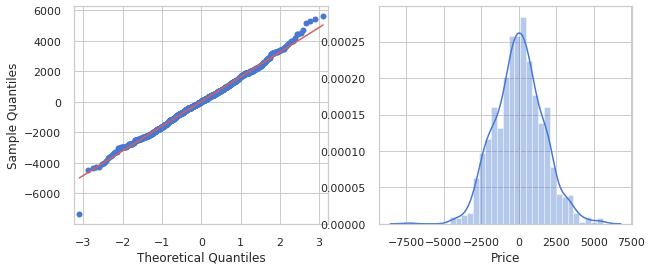

In [75]:
columns = ['Mileage_log', 'Year_ctr_2019','XLE' ,'XSE', 'Hybrid','Price']
rows = toyota[toyota.Mileage > 20000]
model = train_test_plot(rows, columns, regularizer='e')
residuals = model.predict(rows[columns[:-1]])  -  rows['Price']
fig = plt.figure(figsize=(10,4)); axes = fig.subplots(1,2);
qqplot(residuals, line='r',ax=axes[0]); 
sns.distplot(residuals, ax=axes[1]);

### 1.5 Cook's distance to identify influential data points

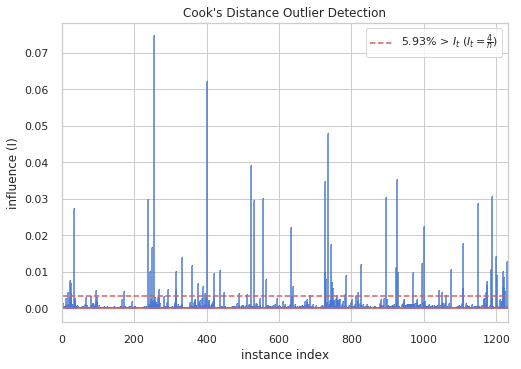

In [0]:
X, y = toyota[['Mileage_std', 'Year_std','XLE' ,'XSE', 'Hybrid']], toyota.Price

# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(X, y)
visualizer.poof()

In [0]:
influential = toyota[(visualizer.distance_ > 0.02) & toyota.Mileage > 20000].index

### 1.6 Model performance

In [0]:
result = performance(toyota, ['Mileage_SQRT_std', 'XLE', 'XSE', 'Hybrid','Price'], rep=50, regularizer='e')
pprint(result)

{'Intercept': {'CI': [16314.628427287902, 16446.952468531064],
               'mean': 16380.790447909483},
 'R2_on_testset': {'CI': [0.4551530987049678, 0.6120439861756742],
                   'mean': 0.533598542440321},
 'RMSE': {'CI': [2143.924309276131, 2153.7882066775396],
          'mean': 2148.8562579768354},
 'coef_CI': [(-2368.340053334809, -2175.407150588045),
             (145.33459156394338, 568.3948236775959),
             (1133.2264201565295, 2185.9525689919096),
             (891.5603286477547, 2010.4685826691896)],
 'coef_means': array([-2271.87360196,   356.86470762,  1659.58949457,  1451.01445566])}


In [0]:
result = performance(toyota, ['Mileage_SQRT_std', 'Year_std', 'Price'], rep=50)
pprint(result)

In [0]:
result = performance(toyota, ['Mileage_SQRT_std', 'Year_std','XLE', 'XSE', 'Hybrid','Price'], rep=50)
pprint(result)

In [0]:
result = performance(toyota[toyota.Mileage > 15000], ['Mileage_SQRT_std', 'Year_std','XLE', 'XSE', 'Hybrid','Price'], rep=50, regularizer='e')
pprint(result)

In [0]:
result = performance(toyota[toyota.Mileage > 15000], ['Mileage_SQRT_std', 'Year_SQ_std','XLE', 'XSE', 'Hybrid','Price'], rep=50)
pprint(result)

In [0]:
result = performance(toyota[toyota.Mileage > 15000], ['Mileage_std', 'Year_SQ_std','XLE', 'XSE', 'Hybrid','Price'], rep=50)
pprint(result)

In [0]:
result = performance(toyota[(toyota.Mileage > 40000)],['Mileage_log_std', 'Year_std','XLE', 'XSE', 'Hybrid','Price'], rep=100, regularizer='e')
pprint(result)

In [0]:
result = performance(toyota[(toyota.Mileage > 15000)],['Mileage_SQRT_std', 'Year_SQ_std','XLE', 'XSE', 'Hybrid','Price'], rep=100, regularizer='e')
pprint(result)

In [0]:
rows = toyota[(toyota.Mileage > 45000) ]
result = performance(rows,['Mileage_std', 'Year_std', 'XLE', 'XSE', 'Hybrid','Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [16484.449806597626, 16725.68517137082],
               'mean': 16605.067488984223},
 'R2_on_testset': {'CI': [0.717824302602993, 0.8549794459231518],
                   'mean': 0.7864018742630724},
 'RMSE': {'CI': [1497.6264289879061, 1536.2927752380544],
          'mean': 1516.9596021129803},
 'coef_CI': [(-1729.879863248837, -1464.6641910699186),
             (1337.3203354795378, 1554.041228158043),
             (396.9359261449175, 1304.6360225588514),
             (-220.4237020573991, 886.8553289581635),
             (790.2492924225835, 2574.1606871489066)],
 'coef_means': array([-1597.27202716,  1445.68078182,   850.78597435,   333.21581345,
        1682.20498979])}


In [0]:
rows = toyota[(toyota.Mileage > 15000) ]
result = performance(rows,['Mileage_std', 'Year_std', 'XLE', 'XSE', 'Hybrid','Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [16245.91090639951, 16351.706396328955],
               'mean': 16298.808651364232},
 'R2_on_testset': {'CI': [0.7096291947541509, 0.8076831251304786],
                   'mean': 0.7586561599423147},
 'RMSE': {'CI': [1533.5098016612726, 1539.1288425701403],
          'mean': 1536.3193221157064},
 'coef_CI': [(-1226.5241684832085, -1087.590873627726),
             (1752.026605804304, 1885.9306190516709),
             (924.9062927050587, 1378.4191359089875),
             (1173.3006387397045, 2065.7553716484595),
             (2115.5715896078405, 2859.7096024177586)],
 'coef_means': array([-1157.05752106,  1818.97861243,  1151.66271431,  1619.52800519,
        2487.64059601])}


In [0]:
rows = toyota[(toyota.Mileage > 15000) ]
result = performance(rows,['Mileage_log', 'Year_ctr_2019', 'XLE', 'XSE', 'Hybrid','Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [37490.78466512189, 40554.54033347882],
               'mean': 39022.66249930036},
 'R2_on_testset': {'CI': [0.6947128210829022, 0.7928524545386614],
                   'mean': 0.7437826378107818},
 'RMSE': {'CI': [1571.5555802200581, 1579.3559841257932],
          'mean': 1575.4557821729256},
 'coef_CI': [(-1440.7037485080943, -1233.6618378157257),
             (-961.2843572820476, -900.8255325558429),
             (882.8112933254416, 1336.7981069589473),
             (1248.5716864937872, 2084.7265347802295),
             (1787.144876720669, 2815.9714687428855)],
 'coef_means': array([-1337.18279316,  -931.05494492,  1109.80470014,  1666.64911064,
        2301.55817273])}


In [0]:
rows = toyota[(toyota.Mileage > 15000) ]
result = performance(rows,['Mileage_std', 'Year_ctr_2019', 'XLE', 'XSE', 'Hybrid','Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [18357.795673580706, 18521.84305454038],
               'mean': 18439.819364060542},
 'R2_on_testset': {'CI': [0.7089424812140893, 0.7986387316045066],
                   'mean': 0.753790606409298},
 'RMSE': {'CI': [1533.579387643982, 1540.0102658989522],
          'mean': 1536.7948267714671},
 'coef_CI': [(-1221.8408158453462, -1096.6779245737462),
             (-856.0953679240341, -804.4606537429562),
             (928.5925944405697, 1313.3084363032447),
             (1140.8726770884189, 2048.23231105791),
             (1958.37005711675, 2667.961452161974)],
 'coef_means': array([-1159.25937021,  -830.27801083,  1120.95051537,  1594.55249407,
        2313.16575464])}


In [0]:
rows = toyota[(toyota.Mileage > 15000) ]
result = performance(rows,['Mileage_ctr', 'Year_SQ_ctr', 'XLE', 'XSE', 'Hybrid','Price'], rep=100, regularizer='e')
pprint(result)

In [0]:
rows = toyota[(toyota.Mileage > 15000) ]
result = performance(rows,['Mileage_log', 'Year_ctr', 'XLE', 'XSE', 'Hybrid','Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [35094.47416402165, 38206.87019605341],
               'mean': 36650.67218003753},
 'R2_on_testset': {'CI': [0.6886188163399866, 0.7906787936958332],
                   'mean': 0.7396488050179099},
 'RMSE': {'CI': [1572.1755201157387, 1579.469701277649],
          'mean': 1575.8226106966938},
 'coef_CI': [(-1440.2915384109335, -1235.9431687784956),
             (899.6397573285408, 960.1110502170591),
             (866.9307039409779, 1343.976216030958),
             (1120.2823647425619, 2056.057510813447),
             (1900.9878602945403, 2659.082539853941)],
 'coef_means': array([-1338.11735359,   929.87540377,  1105.45345999,  1588.16993778,
        2280.03520007])}


## 2. Regression model for Honda Accord

In [0]:
honda = car_listings[(car_listings.Make == 'Honda')].copy()
honda.sort_values(by='Mileage', inplace=True)
honda.reset_index(inplace=True,drop=True)
honda.describe().applymap(lambda x: int(x))

,Year,Price,Mileage
count,1058,1058,1058
mean,2015,17660,42601
std,2,5576,39149
min,2002,1855,604
25%,2015,14972,16419
50%,2017,17792,31845
75%,2018,20988,54455
max,2019,32080,279638


In [0]:
honda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 7 columns):
Year              1058 non-null int64
Make              1058 non-null object
Model             1058 non-null object
Detailed_model    1056 non-null object
Price             1058 non-null float64
Mileage           1058 non-null int64
Website           1058 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 57.9+ KB


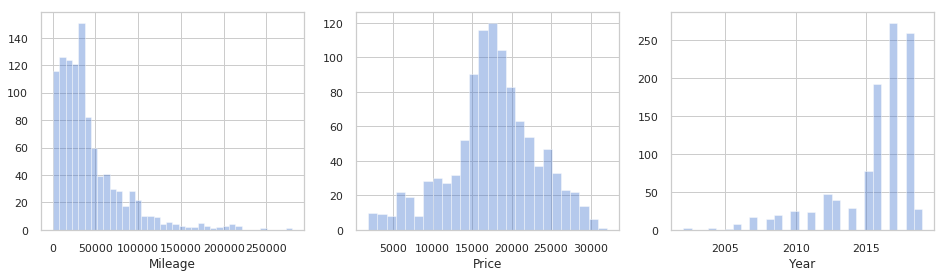

In [0]:
fig = plt.figure(figsize=(16, 4))
axes = fig.subplots(1,3)
sns.distplot(honda.Mileage, kde=False, ax=axes[0])
sns.distplot(honda.Price, kde=False, ax=axes[1])
sns.distplot(honda.Year, kde=False, ax=axes[2])

In [0]:
display(honda.head())
display(honda.tail())
display([honda.Mileage.mean() - 3 * honda.Mileage.std(), honda.Mileage.mean() + 3 * honda.Mileage.std()])

,Year,Make,Model,Detailed_model,Price,Mileage,Website
0,2018,Honda,Accord,EX-L,30100.0,604,ED
1,2018,Honda,Accord,LX,22100.0,825,ED
2,2019,Honda,Accord,Sport 2.0T,27888.0,898,TC
3,2019,Honda,Accord,LX 1.5T,21984.0,1113,TC
4,2019,Honda,Accord,EX,24396.0,1119,ED


,Year,Make,Model,Detailed_model,Price,Mileage,Website
1053,2007,Honda,Accord,LX,2388.0,214844,ED
1054,2007,Honda,Accord,LX Sedan I4,2488.0,214844,TC
1055,2009,Honda,Accord,LX Sedan I4,3988.0,215049,TC
1056,2004,Honda,Accord,EX,1855.0,248143,ED
1057,2005,Honda,Accord,EX V-6,1995.0,279638,ED


[-74848.78084913114, 160050.81109487783]

In [0]:
outliers = honda[honda.Mileage > honda.Mileage.mean() + 3*honda.Mileage.std()]
outliers.shape

(26, 7)

In [0]:
honda.drop(outliers.index, inplace=True)

In [0]:
display(honda.sort_values(by="Year").head())
display(honda.sort_values(by="Year").tail())
display([honda.Year.mean() - 3 * honda.Year.std(), honda.Year.mean() + 3 * honda.Year.std()])

,Year,Make,Model,Detailed_model,Price,Mileage,Website
1022,2002,Honda,Accord,VP with Side Airbags Sedan,2688.0,138375,TC
1031,2006,Honda,Accord,EX-L Sedan,4995.0,158697,TC
945,2006,Honda,Accord,EX-L Sedan,7495.0,91948,TC
1025,2006,Honda,Accord,EX-L V6 with Navigation Sedan,6499.0,141303,TC
976,2006,Honda,Accord,EX-L Sedan,6991.0,100835,TC


,Year,Make,Model,Detailed_model,Price,Mileage,Website
32,2019,Honda,Accord,EX-L,26399.0,3540,ED
35,2019,Honda,Accord,Touring,30194.0,3627,ED
40,2019,Honda,Accord,EX-L,26385.0,3911,ED
15,2019,Honda,Accord,EX-L,28440.0,2067,ED
96,2019,Honda,Accord,Sport,22768.0,6927,ED


[2008.0193203096405, 2023.6957959694291]

In [0]:
outliers_year = honda[honda.Year < honda.Year.mean() - 3*honda.Year.std()]
outliers_year.shape

(26, 7)

In [0]:
honda.drop(outliers_year.index, inplace=True)

In [0]:
honda.describe()

,Year,Price,Mileage
count,1006.000000,1006.000000,1006.000000
mean,2016.084493,18306.577535,36710.805169
std,2.217034,4899.383752,28109.336051
min,2009.000000,5490.000000,604.000000
25%,2015.000000,15487.250000,15759.250000
50%,2017.000000,17995.000000,30396.000000
75%,2018.000000,21167.500000,48762.000000
max,2019.000000,32080.000000,153341.000000


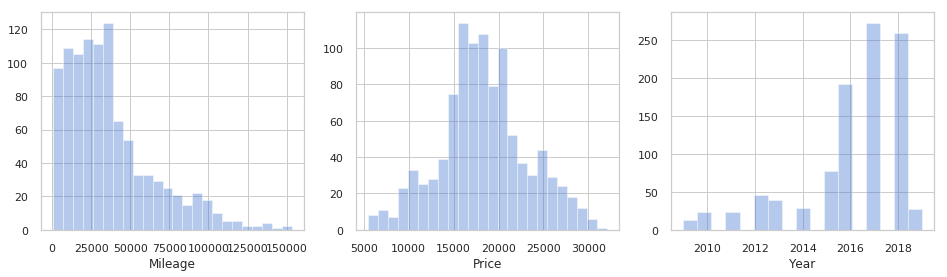

In [0]:
fig = plt.figure(figsize=(16, 4))
axes = fig.subplots(1,3)
sns.distplot(honda.Mileage, kde=False, ax=axes[0])
sns.distplot(honda.Price, kde=False, ax=axes[1])
sns.distplot(honda.Year, kde=False, ax=axes[2])

---

In [0]:
honda['Year_ctr'] = transform(honda.Year, 'center')
honda['Year_ctr_2019'] = 2019 - honda.Year 
honda['Year_ctr_2019_SQ'] = honda.Year_ctr_2019**2
honda['Year_std'] = transform(honda.Year, 'standardize')
honda['Year_SQ_std'] = transform(honda.Year **2, 'standardize')
honda['Mileage_ctr'] = transform(honda.Mileage, 'center')
honda['Mileage_SQRT_std'] = transform(transform(honda.Mileage, np.sqrt), 'standardize')
honda['Mileage_std'] = transform(honda.Mileage, 'standardize')
honda['Mileage_log'] = transform(honda.Mileage, np.log2)
honda['LX'] = [1 if entry else 0 for entry in honda.Detailed_model.str.contains('LX', na=False)]
honda['ALL_EX'] = [1 if entry else 0 for entry in honda.Detailed_model.str.contains('EX', na=False)]
honda['EXL'] = [1 if entry else 0 for entry in honda.Detailed_model.str.contains('EX-L', na=False)]
honda['EX'] = [1 if (ex == 1) & (exl == 0) else 0 for ex, exl in zip(honda.ALL_EX.to_list(), honda.EXL.to_list())]
honda['Sport'] = [1 if entry else 0 for entry in honda.Detailed_model.str.contains('Sport', na=False)]
honda['Touring'] = [1 if entry else 0 for entry in honda.Detailed_model.str.contains('Touring', na=False)]

---

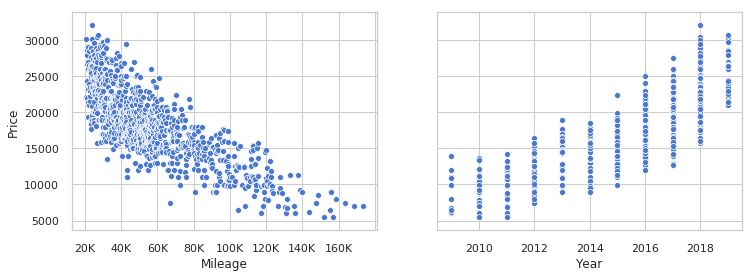

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4),sharey=True)
sns.scatterplot(honda.Mileage, honda.Price, ax=ax1)
ax1.set_xticklabels(['0','20K', '40K', '60K', '80K', '100K', '120K', '140K','160K']);
sns.scatterplot(honda.Year, honda.Price, ax=ax2);

In [0]:
honda.corr()

,Year,Price,Mileage
Year,1.000000,0.783722,-0.784389
Price,0.783722,1.000000,-0.779174
Mileage,-0.784389,-0.779174,1.000000


In [0]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_test = honda[['Mileage', 'Year']].copy()
vif_test['Intercept'] = np.ones(vif_test.shape[0])

pd.Series([variance_inflation_factor(vif_test.values, i) for i in range(vif_test.shape[1])], index=vif_test.columns)

Mileage      2.599195e+00
Year         2.599195e+00
Intercept    2.156363e+06
dtype: float64

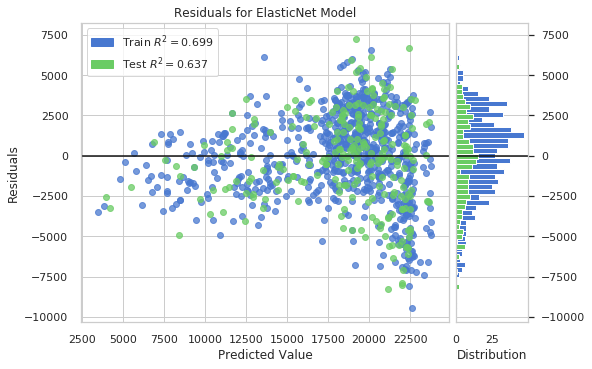

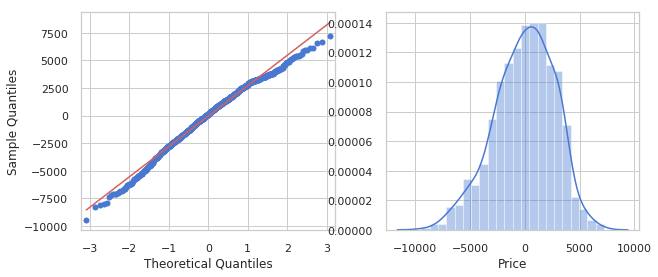

In [0]:

columns = ['Mileage_std', 'Year_std','Price']
data = honda[columns]
model = train_test_plot(data,columns, regularizer='e')
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(10,4));
axes = fig.subplots(1,2);
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1]);

In [0]:
result = performance(honda,['Mileage_std', 'Year_std', 'Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [18194.53160158444, 18404.611470138636],
               'mean': 18299.571535861538},
 'R2_on_testset': {'CI': [0.6308366808165249, 0.731897084242493],
                   'mean': 0.6813668825295089},
 'RMSE': {'CI': [2749.703832494535, 2753.783860327905],
          'mean': 2751.74384641122},
 'coef_CI': [(-2204.787076162898, -1969.0865331085658),
             (2072.9866501938586, 2299.037784178714)],
 'coef_means': array([-2086.93680464,  2186.01221719])}


In [0]:
honda.groupby(by='Detailed_model').agg({'Price':['count', 'mean', 'std'], 'Mileage': 'mean', 'Year': 'mean'})

Price  ...         Year
                                            count  ...         mean
Detailed_model                                     ...             
1.5T LX FWD                                     1  ...  2018.000000
1.5T Sport FWD                                  2  ...  2018.000000
2.0T Sport FWD                                  1  ...  2018.000000
2.0T Touring FWD                                2  ...  2018.000000
EX                                             55  ...  2015.563636
EX 1.5T                                         6  ...  2018.166667
EX Coupe                                        2  ...  2017.000000
EX Coupe I4                                     6  ...  2011.666667
EX Sedan                                        8  ...  2017.000000
EX Sedan I4                                    22  ...  2014.318182
EX w/Honda Sensing                              4  ...  2016.500000
EX with Honda Sensing Coupe                     1  ...  2017.000000
EX with Honda Sensing Coupe I4                  1  ...  2016.000000
EX with Honda Sensing Sedan                     2  ...  2017.000000
EX with Honda Sensing Sedan I4                  1  ...  2016.000000
EX-L                                           89  ...  2016.561798
EX-L 1.5T                                       9  ...  2018.000000
EX-L 2.0T                                       3  ...  2018.000000
EX-L Coupe                                      4  ...  2017.000000
EX-L Coupe I4                                   7  ...  2014.142857
EX-L FWD                                        1  ...  2017.000000
EX-L FWD Used                                   1  ...  2017.000000
EX-L Sedan                                     14  ...  2017.000000
EX-L Sedan I4                                  20  ...  2013.900000
EX-L V-6                                       36  ...  2013.861111
EX-L V-6 w/Navigation                           1  ...  2013.000000
EX-L V-6 w/Navigation and Honda Sensing         5  ...  2016.600000
EX-L V6 Coupe                                   9  ...  2014.222222
EX-L V6 Sedan                                  22  ...  2013.500000
EX-L V6 with Honda Sensing/Navigation Sedan     2  ...  2016.500000
...                                           ...  ...          ...
LX Sedan I4                                    48  ...  2015.104167
LX w/Honda Sensing                              4  ...  2016.250000
LX with Honda Sensing Sedan I4                  2  ...  2016.000000
LX-P                                            7  ...  2010.285714
LX-P Sedan I4                                   5  ...  2011.600000
LX-S                                            6  ...  2013.333333
LX-S Coupe                                      3  ...  2017.000000
LX-S Coupe I4                                   3  ...  2014.666667
LX-S w/Honda Sensing                            1  ...  2016.000000
SE                                              8  ...  2011.500000
SE Sedan I4                                     8  ...  2011.750000
Sport                                         127  ...  2016.897638
Sport 1.5T                                     21  ...  2018.095238
Sport 2.0T                                      3  ...  2018.333333
Sport SE FWD                                    1  ...  2017.000000
Sport Sedan                                    24  ...  2017.000000
Sport Sedan I4                                 38  ...  2015.631579
Sport Special Edition                          13  ...  2017.000000
Sport Special Edition Sedan                    26  ...  2017.000000
Sport w/Honda Sensing                           2  ...  2016.500000
Sport with Honda Sensing Sedan                  2  ...  2017.000000
Sport with Honda Sensing Sedan I4               4  ...  2016.000000
Touring                                        26  ...  2018.076923
Touring 1.5T                                   11  ...  2018.000000
Touring 2.0T                                    8  ...  2018.125000
Touring Coupe                   

In [0]:
honda.Detailed_model.unique().shape

(78,)

In [0]:
display(honda[honda.Detailed_model.str.contains('Sport',na=False)].shape)
display(honda[honda.Detailed_model.str.contains('LX',na=False)].shape)
display(honda[honda.Detailed_model.str.contains('Touring',na=False)].shape)
display(honda[honda.Detailed_model.str.contains('EX',na=False)].shape)

(264, 17)

(290, 17)

(66, 17)

(367, 17)

In [0]:
display(honda[honda.Detailed_model.str.contains('LX',na=False)].Price.mean())
display(honda[honda.Detailed_model.str.contains('EX',na=False)].Price.mean())
display(honda[honda.Detailed_model.str.contains('Sport',na=False)].Price.mean())
display(honda[honda.Detailed_model.str.contains('Touring',na=False)].Price.mean())

16053.124137931034

18422.623978201635

19148.81818181818

25891.030303030304

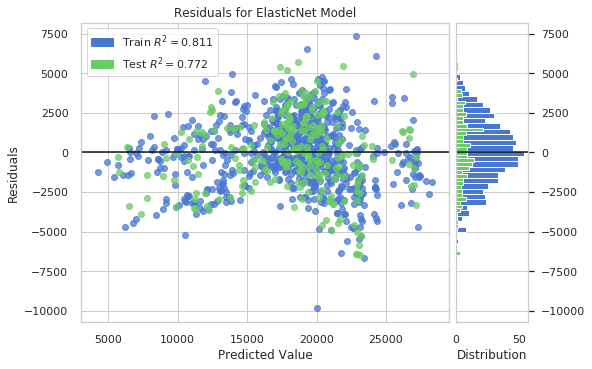

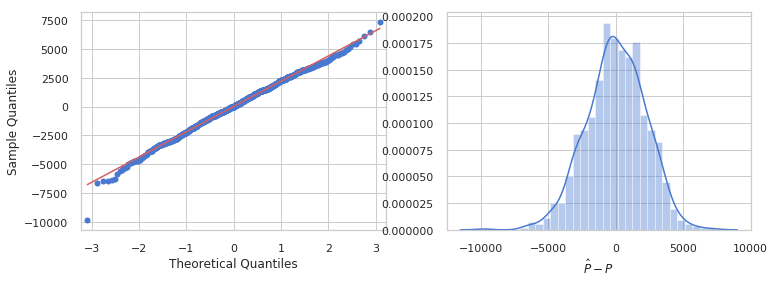

In [0]:
columns = ['Mileage_std', 'Year_std', 'ALL_EX', 'Sport', 'Touring', 'Price']
data = honda[columns]
model = train_test_plot(data,columns, regularizer='e')
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(12,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
axes[1].set_xlabel('$\hat{P} - P$');

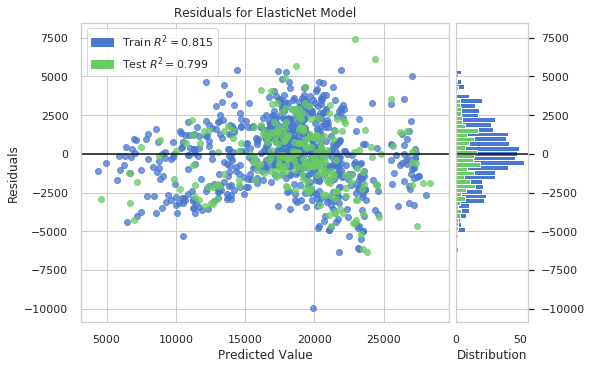

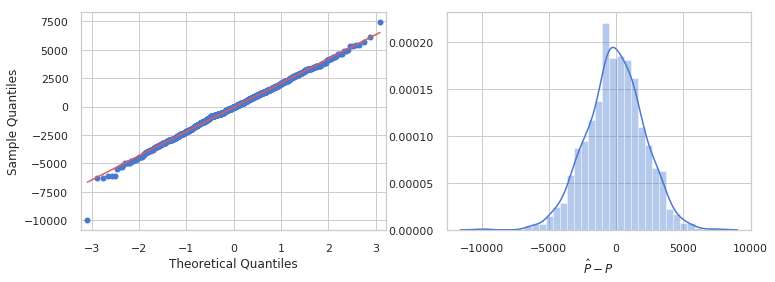

In [0]:
columns = ['Mileage_std', 'Year_std', 'EX', 'EXL', 'Sport', 'Touring', 'Price']
data = honda[columns]
model = train_test_plot(data,columns, regularizer='e')
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(12,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
axes[1].set_xlabel('$\hat{P} - P$');

In [0]:
hybrid = honda[honda.Detailed_model.str.contains('Hybrid', na=False)]
display(hybrid.shape)
display(honda.shape)
display(honda.drop(hybrid.index).shape)

(12, 17)

(1006, 17)

(994, 17)

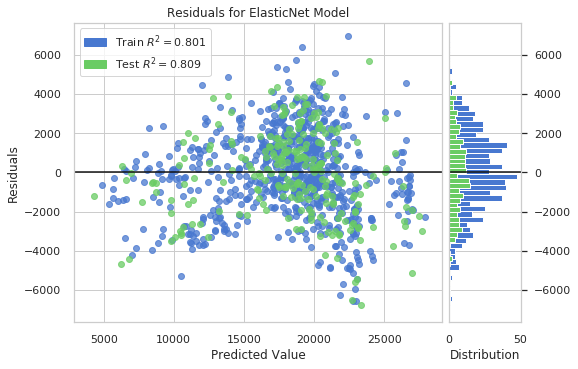

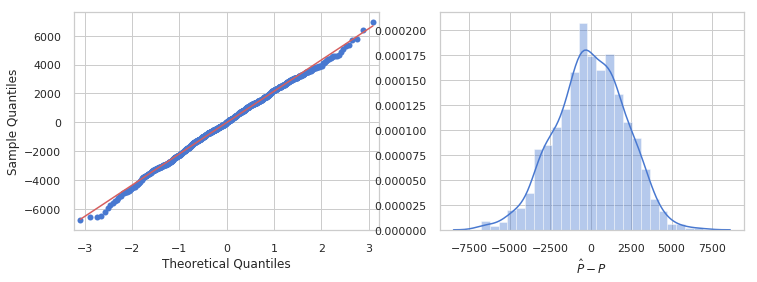

In [0]:
columns = ['Mileage_std', 'Year_std', 'EX', 'Sport', 'Touring', 'Price']
data = honda[columns].drop(hybrid.index)
model = train_test_plot(data,columns, regularizer='e')
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(12,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
axes[1].set_xlabel('$\hat{P} - P$');

In [0]:
result = performance(honda,['Mileage_std', 'Year_std', 'EX', 'Sport', 'Touring', 'Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [16413.421151309718, 16657.98649131989],
               'mean': 16535.703821314804},
 'R2_on_testset': {'CI': [0.7653959238299456, 0.832658733365265],
                   'mean': 0.7990273285976053},
 'RMSE': {'CI': [2182.7843115131373, 2188.4021404053256],
          'mean': 2185.5932259592314},
 'coef_CI': [(-2075.9016998847906, -1837.178346747136),
             (1956.2558245341704, 2192.3210224094637),
             (2424.3817692148446, 2794.5580897218565),
             (1257.3646353690704, 1684.399109938937),
             (6277.44732555714, 6951.959761843443)],
 'coef_means': array([-1956.54002332,  2074.28842347,  2609.46992947,  1470.88187265,
        6614.7035437 ])}


In [0]:
print(toyota.Mileage.std())
print(honda.Mileage.std())

24514.625215627075
28109.336051205748


In [0]:
result = performance(honda.drop(hybrid.index),['Mileage_std', 'Year_std', 'EX', 'Sport', 'Touring', 'Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [16389.49080403144, 16643.50918463796],
               'mean': 16516.4999943347},
 'R2_on_testset': {'CI': [0.7616792137182801, 0.8387060087922994],
                   'mean': 0.8001926112552897},
 'RMSE': {'CI': [2162.432957268665, 2167.7451298631863],
          'mean': 2165.0890435659257},
 'coef_CI': [(-2034.5897378861855, -1847.1843586222176),
             (1959.0190323706322, 2181.8858561939687),
             (2377.2158734271784, 2806.37810887311),
             (1274.5978151991733, 1691.359728820599),
             (6252.180534592053, 6902.470626429385)],
 'coef_means': array([-1940.88704825,  2070.45244428,  2591.79699115,  1482.97877201,
        6577.32558051])}


In [0]:
result = performance(honda.drop(hybrid.index),['Mileage_std', 'Year_std', 'EX','EXL', 'Sport', 'Touring', 'Price'], rep=100, regularizer='r')
pprint(result)

{'Intercept': {'CI': [16336.880979728121, 16621.844293655646],
               'mean': 16479.362636691883},
 'R2_on_testset': {'CI': [0.7718898452128509, 0.8483354976226489],
                   'mean': 0.8101126714177499},
 'RMSE': {'CI': [2098.504652559484, 2103.5902380349794],
          'mean': 2101.0474452972317},
 'coef_CI': [(-2063.928593236786, -1853.2467256959253),
             (1930.5081417417769, 2166.1595480421656),
             (1037.202522004371, 1521.771011558058),
             (2982.1173341592807, 3394.7150043913875),
             (1342.5217632339718, 1734.9358652773963),
             (6218.034065458761, 7056.925026557071)],
 'coef_means': array([-1958.58765947,  2048.33384489,  1279.48676678,  3188.41616928,
        1538.72881426,  6637.47954601])}


In [0]:
result = performance(honda,['Mileage_log', 'Year_ctr_2019', 'EX', 'EXL', 'Sport', 'Touring', 'Price'], rep=100, regularizer='r')
pprint(result)

{'Intercept': {'CI': [38194.615958937655, 40717.53877460704],
               'mean': 39456.07736677235},
 'R2_on_testset': {'CI': [0.7807344520149506, 0.850321078192082],
                   'mean': 0.8155277651035163},
 'RMSE': {'CI': [2078.5318714577356, 2084.4299885196983],
          'mean': 2081.480929988717},
 'coef_CI': [(-1434.8711555077448, -1254.6225973738806),
             (-1120.004802829483, -1017.2004729658),
             (1015.4943991980899, 1465.7896146854682),
             (2711.186573593047, 3141.604534648137),
             (1302.2757930313887, 1719.822337951584),
             (6058.449560894514, 6718.469688103163)],
 'coef_means': array([-1344.74687644, -1068.6026379 ,  1240.64200694,  2926.39555412,
        1511.04906549,  6388.4596245 ])}


In [0]:
result = performance(honda,['Mileage_log', 'Year_ctr_2019_SQ', 'EX', 'EXL', 'Sport', 'Touring', 'Price'], rep=100, regularizer='r')
pprint(result)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The def

{'Intercept': {'CI': [42446.469745463124, 44863.53701441725],
               'mean': 43655.003379940186},
 'R2_on_testset': {'CI': [0.7510495880308007, 0.8289829340454672],
                   'mean': 0.7900162610381339},
 'RMSE': {'CI': [2211.7276214461253, 2217.1316535940305],
          'mean': 2214.429637520078},
 'coef_CI': [(-1846.6196320699983, -1682.0963124821778),
             (-95.8278840303868, -85.24803365333776),
             (975.8235360025326, 1413.370413679401),
             (2685.4779307004583, 3158.4615203948442),
             (1456.4152678362907, 1857.2859720240472),
             (6291.853243748043, 7052.138959156015)],
 'coef_means': array([-1764.35797228,   -90.53795884,  1194.59697484,  2921.96972555,
        1656.85061993,  6671.99610145])}


In [0]:
print(honda[honda.EXL == 1].Price.mean())
honda[honda.EX == 1].Price.mean()

19061.386100386102


16890.777777777777

In [0]:
honda.columns

Index(['Year', 'Make', 'Model', 'Detailed_model', 'Price', 'Mileage',
       'Website', 'Year_ctr', 'Year_std', 'Mileage_ctr', 'Mileage_SQRT_std',
       'Year_SQ_std', 'Mileage_std', 'LX', 'EX', 'Sport', 'Touring', 'ALL_EX',
       'EXL', 'Year_ctr_2019'],
      dtype='object')

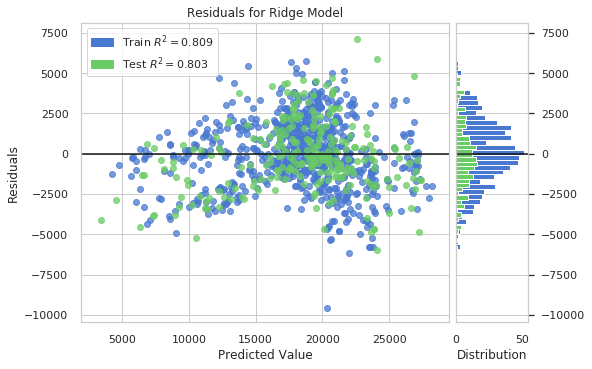

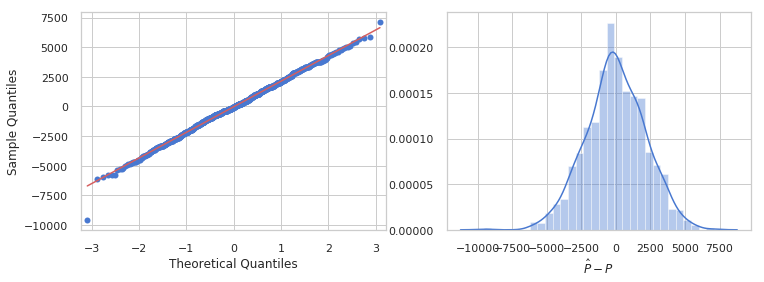

In [0]:
columns = ['Mileage_std', 'Year_std', 'EXL', 'Sport', 'Touring', 'Price']
data = honda[columns]
model = train_test_plot(data,columns, regularizer='r')
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(12,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
axes[1].set_xlabel('$\hat{P} - P$');

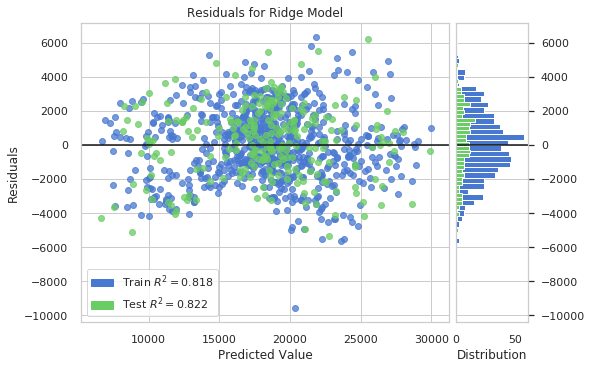

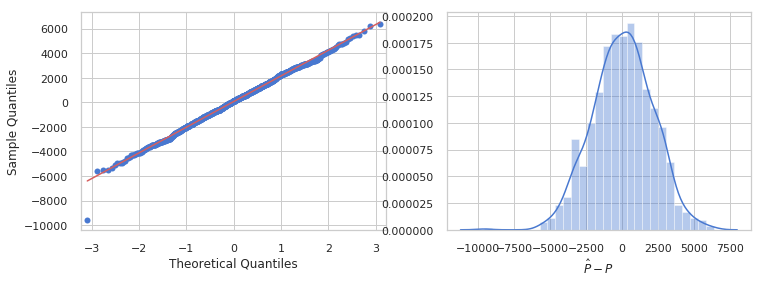

In [0]:
columns = ['Mileage_log', 'Year_ctr_2019', 'EX', 'EXL', 'Sport', 'Touring', 'Price']
model = train_test_plot(honda,columns,regularizer='r')
residuals = model.predict(honda[columns].drop('Price', axis=1))  -  honda.Price
fig = plt.figure(figsize=(12,4));axes = fig.subplots(1,2);
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1]);axes[1].set_xlabel('$\hat{P} - P$');

In [0]:
model.coef_

array([-1334.99218643, -1093.3898091 ,  1192.27293137,  2821.64782081,
        1448.03883597,  6146.89085376])

In [0]:
model.intercept_

39502.158108646865

In [0]:
result = performance(honda,['Mileage_log', 'Year_ctr_2019', 'EX', 'EXL', 'Sport', 'Touring', 'Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [38338.1260978098, 40810.58653161612],
               'mean': 39574.35631471296},
 'R2_on_testset': {'CI': [0.7822354765721697, 0.849317525026879],
                   'mean': 0.8157765007995244},
 'RMSE': {'CI': [2079.1956755727538, 2086.65504142483],
          'mean': 2082.925358498792},
 'coef_CI': [(-1431.4573727602524, -1260.5230930793814),
             (-1117.7751486454881, -1023.5573297383098),
             (828.9440545038926, 1315.9106007924622),
             (2586.379091716928, 3024.520754648189),
             (1185.2169898974355, 1574.90396621278),
             (5806.230328387069, 6550.750342426088)],
 'coef_means': array([-1345.99023292, -1070.66623919,  1072.42732765,  2805.44992318,
        1380.06047806,  6178.49033541])}


In [0]:
result = performance(honda,['Mileage_log', 'Year_ctr_2019_SQ', 'ALL_EX', 'Sport', 'Touring', 'Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [43264.061920244145, 45734.23636106755],
               'mean': 44499.14914065585},
 'R2_on_testset': {'CI': [0.7319949908017631, 0.8160003279450094],
                   'mean': 0.7739976593733863},
 'RMSE': {'CI': [2297.4996708210447, 2338.5278112123187],
          'mean': 2318.0137410166817},
 'coef_CI': [(-1854.951793672975, -1690.4827923464397),
             (-99.54246207326634, -90.11597749712553),
             (1368.0465823855038, 1814.2759530323738),
             (455.72373641603593, 948.3446004308937),
             (4546.084835245771, 5356.2131307900345)],
 'coef_means': array([-1772.71729301,   -94.82921979,  1591.16126771,   702.03416842,
        4951.14898302])}


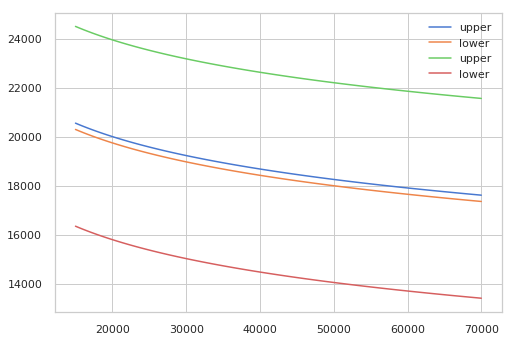

In [0]:
fig, ax = plt.subplots()
pred_interval = 1.96 * np.sqrt(np.sum(residuals**2)/(residuals.shape[0] - 1))
conf_interval = 1.96 * np.sqrt(np.sum(residuals**2)/(residuals.shape[0] - 1))/np.sqrt(residuals.shape[0])

synthetic = np.zeros((100, 6))
mileage = np.linspace(15000, 70000, 100)
synthetic[:,0] = np.log2(mileage)
synthetic[:,1] = 3
synthetic[:,3] = 1

predictions = model.predict(synthetic)
upper, lower = predictions + pred_interval, predictions - pred_interval
#sns.scatterplot(x=mileage, y=honda.Price, ax=ax,color='r', label="Actual values")
sns.lineplot(x=mileage, y=predictions + conf_interval, ax=ax, label="upper")
sns.lineplot(x=mileage, y=predictions - conf_interval, ax=ax, label='lower')
sns.lineplot(x=mileage, y=predictions + pred_interval, ax=ax, label="upper")
sns.lineplot(x=mileage, y=predictions - pred_interval, ax=ax, label='lower')

This is some <sup>superscript</sup> text

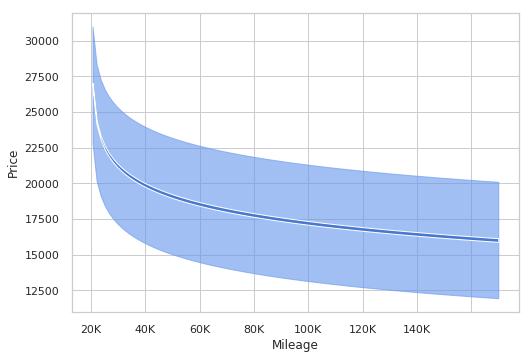

In [0]:
pred_interval = 1.96 * np.sqrt(np.sum(residuals**2)/(residuals.shape[0] - 1))
conf_interval = 1.96 * np.sqrt(np.sum(residuals**2)/(residuals.shape[0] - 1))/np.sqrt(residuals.shape[0])

synthetic = np.zeros((100, 6))
mileage = np.linspace(500, 150000, 100)
year = mileage //15000
synthetic[:,0] = np.log2(mileage)
synthetic[:,1] = 3
synthetic[:,3] = 1

predictions = model.predict(synthetic)

fig, ax = plt.subplots()

ax.fill_between(mileage, predictions - pred_interval, predictions + pred_interval, alpha=0.6, color='cornflowerblue')
ax.fill_between(mileage, predictions - conf_interval, predictions + conf_interval)
ax.set_xticklabels(['0','20K', '40K', '60K', '80K', '100K', '120K', '140K'])
ax.set_xlabel('Mileage');
ax.set_ylabel('Price');

In [0]:
model.coef_

array([-1394.63931126, -1045.04074073,  1182.50604361,  2876.77680838,
        1459.38198605,  6254.1908078 ])

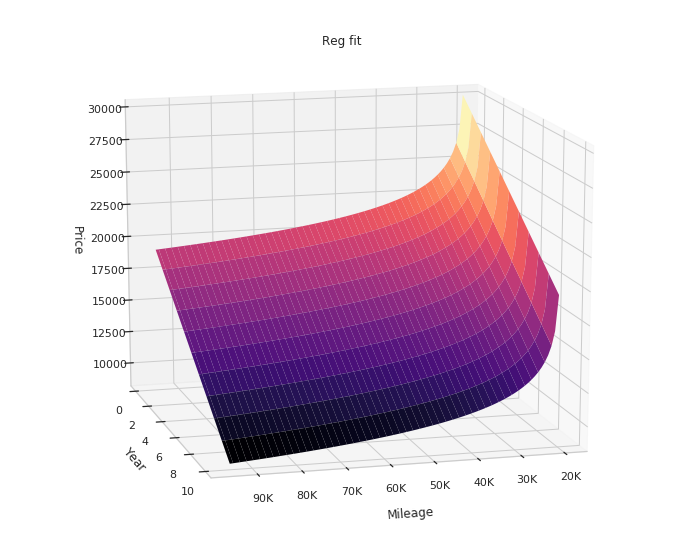

In [0]:
from mpl_toolkits import mplot3d
def f(m, y):
  return model.coef_.dot(np.array([np.log2(m), y, 0, 1, 0, 0])) + model.intercept_
X, Y = np.meshgrid(mileage, year)

Z = f(X, Y)
fig = plt.figure(figsize=(12,10))
ax=fig.add_subplot(111,projection='3d')

ax.plot_surface(X,Y,Z, cmap='magma',edgecolor='none')

ax.set_title('Reg fit');
ax.set_xlabel('\nMileage', linespacing=3.2)
ax.set_ylabel('\nYear')
ax.set_zlabel('\nPrice', linespacing=3.2);
ax.set_xticklabels(['20K', '30K', '40K', '50K', '60K', '70K', '80K', '90K'])
ax.view_init(15, 75)

In [0]:
model.coef_

array([-1410.7039922 , -1055.16763751,  2504.38950342,  1528.11708271,
        6453.18417513])

In [0]:
honda[(honda.Detailed_model.str.contains('EX-L', na=False)) & honda.Mileage.between(20000, 70000)]

,Year,Make,Model,Detailed_model,Price,Mileage,Website,Year_ctr,Year_ctr_2019,Year_ctr_2019_SQ,Year_std,Year_SQ_std,Mileage_ctr,Mileage_SQRT_std,Mileage_std,Mileage_log,LX,ALL_EX,EXL,EX,Sport,Touring
322,2017,Honda,Accord,Hybrid EX-L,24454.0,20095,TC,0.915507,2,4,0.413148,0.413005,-16615.805169,-0.499602,-0.591407,14.294549,0,1,1,0,0,0
331,2017,Honda,Accord,EX-L FWD,17995.0,20700,CG,0.915507,2,4,0.413148,0.413005,-16010.805169,-0.470107,-0.569874,14.337343,0,1,1,0,0,0
333,2013,Honda,Accord,EX-L,19000.0,20876,ED,-3.084493,6,36,-1.391962,-1.392501,-15834.805169,-0.461607,-0.563609,14.349558,0,1,1,0,0,0
335,2017,Honda,Accord,V6 EX-L FWD,19999.0,21128,CG,0.915507,2,4,0.413148,0.413005,-15582.805169,-0.449500,-0.554640,14.366869,0,1,1,0,0,0
340,2016,Honda,Accord,EX-L V-6,16986.0,21534,ED,-0.084493,3,9,-0.038130,-0.038708,-15176.805169,-0.430145,-0.540189,14.394329,0,1,1,0,0,0
347,2018,Honda,Accord,EX-L with Navigation 1.5T,24991.0,21727,TC,1.915507,1,1,0.864425,0.864941,-14983.805169,-0.421008,-0.533320,14.407201,0,1,1,0,0,0
349,2017,Honda,Accord,Hybrid EX-L,23000.0,21852,TC,0.915507,2,4,0.413148,0.413005,-14858.805169,-0.415112,-0.528870,14.415478,0,1,1,0,0,0
351,2018,Honda,Accord,EX-L w/Navi,23000.0,21860,ED,1.915507,1,1,0.864425,0.864941,-14850.805169,-0.414735,-0.528586,14.416006,0,1,1,0,0,0
357,2016,Honda,Accord,EX-L w/Navigation and Honda Sensing,16899.0,22229,ED,-0.084493,3,9,-0.038130,-0.038708,-14481.805169,-0.397431,-0.515452,14.440155,0,1,1,0,0,0
359,2016,Honda,Accord,EX-L,16999.0,22312,ED,-0.084493,3,9,-0.038130,-0.038708,-14398.805169,-0.393558,-0.512498,14.445532,0,1,1,0,0,0


In [0]:
honda[(honda.Mileage > 50000) & (honda.Mileage < 60000) & (honda.Year == 2016) & (honda.Detailed_model.str.contains('EX-L',na=False))].Price.mean()

17565.7

In [0]:
model.predict([[np.log2(50000), 3, 0, 1, 0, 0]])

array([18257.42947375])

In [0]:
print(18257.42947375 + conf_interval, 18257.42947375 - conf_interval)

18386.136134996406 18128.72281250359
